In [2]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager ipygany
!jupyter labextension install jupyter-matplotlib

Building jupyterlab assets (production, minimized)
Building jupyterlab assets (production, minimized)


In [2]:
!jupyter labextension uninstall jupyter-matplotlib && jupyter labextension uninstall @jupyter-widgets/jupyterlab-manager

JupyterLab cannot uninstall jupyter-matplotlib since it was installed outside of JupyterLab. Use the same method used to install this extension to uninstall this extension.
JupyterLab cannot uninstall this extension. Use your Python package manager (pip, conda, etc.) to uninstall the package jupyterlab_widgets


In [2]:
!pip3 install ipympl
!pip3 install matplotlib



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import random
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

In [4]:
class Cell:
    def __init__(self, lower, upper):
        self.lower = lower
        self.upper = upper

        # Start with 1 attempt so sampling math works out
        self.num_attempts = 1
        self.num_fails = 0

    def setAttempts(self, n):
        self.num_attempts = n

    def setFails(self, n):
        self.num_fails = n
            
class Cyl:
    def __init__(self, radius, height):
        self.radius = radius
        self.height = height
        
    def isInside(self, x, y, z):
        radius_squared = x ** 2 + y ** 2
        return radius_squared <= self.radius ** 2 and z <= self.height/2 and z >= -self.height/2
    
    def samplePosInRange(self, lower, upper):
        r_squared = random.uniform(self.radius ** 2 * lower[0] ** 2, self.radius ** 2 * upper[0] ** 2)
        theta = random.uniform(2 * math.pi * lower[1], 2 * math.pi * upper[1])
        
        x = math.sqrt(r_squared) * math.cos(theta)
        y = math.sqrt(r_squared) * math.sin(theta)
        z = random.uniform(lower[2] * self.height - self.height/2.0 , upper[2] * self.height - self.height/2.0)
        
        return (x,y,z)
    
    def sample(self):
        return self.samplePosInRange((0,0,0), (1,1,1))
    
    def sampleCartInRange(self, lower, upper):
        while True:
            x = -self.radius + 2 * self.radius * random.uniform(lower[0], upper[0])
            y = -self.radius + 2 * self.radius * random.uniform(lower[1], upper[1])
            z = -self.height/2 + self.height * random.uniform(lower[2], upper[2])
            
            if self.isInside(x,y,z):
                return (x,y,z)
    
    def sampleRadialGrid(self, n_r, n_theta, n_h):
        delta_r = self.radius ** 2 / n_r
        delta_theta = 2 * math.pi / n_theta
        delta_h = self.height / n_h
        
        # Random integer in [0,n]
        r_squared = delta_r * random.randint(1, n_r) ** 2
        # Random integer in [0,n) because 2pi = 0
        theta = delta_theta * random.randrange(0,n_theta)
        
        x = math.sqrt(r_squared) * math.cos(theta)
        y = math.sqrt(r_squared) * math.sin(theta)
        
        # Random integer in [0,n]
        z = -self.height/2 + delta_h * random.randint(0,n_h)
                
        return (x,y,z)
    
    def sampleCartesianGrid(self, n_x, n_y, n_z):
        delta_x = 2 * self.radius / n_x
        delta_y = 2 * self.radius / n_y
        delta_z = self.height / n_z
        
        while True:
            x = -self.radius + delta_x * random.randint(0,n_x)
            y = -self.radius + delta_y * random.randint(0,n_y)
            z = -self.height/2 + delta_z * random.randint(0,n_z)
            
            if self.isInside(x,y,z):
                return (x,y,z)
            
    def sampleRadialCells(self, bias):
        if not self.cells:
            print("CELLS NOT CONSTRUCTED")
            return (0,0,0)
        
        if random.random() > bias:
            return self.sample()
        
        total_attempts = sum([c.num_attempts for c in self.cells])
        
        probs = [c.num_attempts / total_attempts for c in self.cells]
        cur_cell = np.random.choice(self.cells, p = probs)
        
        return self.sampleRadialCell(cur_cell)
            
    def sampleCartCells(self, bias):
        if not self.cells:
            print("CELLS NOT CONSTRUCTED")
            return (0,0,0)
        
        if random.random() > bias:
            return self.sample()
        
        total_attempts = sum([c.num_attempts for c in self.cells])
        
        # Sampling from a discrete distribution
        probs = [c.num_attempts / total_attempts for c in self.cells]
        cur_cell = np.random.choice(self.cells, p = probs)
        
        return self.sampleCartCell(cur_cell)
    
    def sampleRadialCell(self, cell):
        return self.samplePosInRange(cell.lower, cell.upper)
    
    def sampleCartCell(self, cell):
        return self.sampleCartInRange(cell.lower, cell.upper)
    
    def constructCells(self, n_r, n_theta, n_h):
        delta_r = 1.0 / n_r
        delta_theta = 1.0 / n_theta
        delta_h = 1.0 / n_h
        
        self.cells = []
        
        for r in range(n_r):
            for t in range(n_theta):
                for h in range(n_h):
                    lower = [r * delta_r, t*delta_theta, h*delta_h]
                    upper = [lower[0] + delta_r, lower[1] + delta_theta, lower[2] + delta_h]
                    
                    self.cells.append(Cell(lower, upper))
        

In [6]:
c = Cyl(2,3)
# c.constructCells(4,4,4)
c.constructCells(4, 4, 4)

In [393]:
for i in range(len(c.cells)):
    if i % 2 == 0:
        c.cells[i].num_attempts = 100

In [412]:
c.cells[40].num_attempts = 100
c.cells[60].num_attempts = 60

# Sample Visualization

In [21]:
xs = []
ys = []
zs = []
num_samples = 5000

for i in range(num_samples):
    x, y, z = c.samplePosInRange((0, 0.5, 0), (1, 1, 1))
    # x, y, z = c.sampleRadialGrid(10, 10, 10)
    # x, y, z = c.sampleCartesianGrid(10, 10, 10)
    # x, y, z = c.sampleCartCells(0.5)
    # x, y, z = c.sampleRadialCells(0.5)
    # x, y, z = c.sampleCartInRange((0.5, 0.5, 0), (1, 1, 1))
    
    xs.append(x)
    ys.append(y)
    zs.append(z)

In [22]:
xs_o = []
ys_o = []
zs_o = []
num_samples = 5000

for i in range(num_samples):
    x, y, z = c.samplePosInRange((0, 0, 0), (1, 0.5, 1))
    # x, y, z = c.sampleRadialGrid(10, 10, 10)
    # x, y, z = c.sampleCartesianGrid(10, 10, 10)
    # x, y, z = c.sampleCartCells(0.5)
    # x, y, z = c.sampleRadialCells(0.5)
    # x, y, z = c.sampleCartInRange((0.5, 0.5, 0), (1, 1, 1))
    
    xs_o.append(x)
    ys_o.append(y)
    zs_o.append(z)

/tmp/ipykernel_266146/1834811879.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


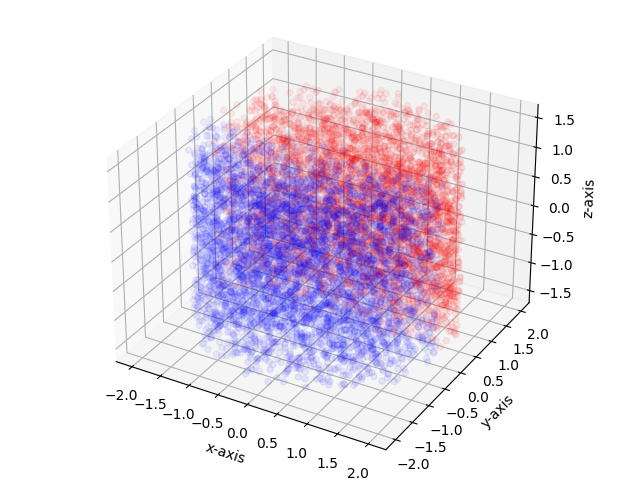

In [24]:
%matplotlib widget

# creating figure
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
plot_geeks = ax.scatter(xs, ys, zs, color=[0,0,1,0.1])
plot_geeks = ax.scatter(xs_o, ys_o, zs_o, color=[1,0,0,0.1])
  
# setting title and labels
ax.set_title("Cylinder Sampling")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
# displaying the plot
plt.show()

In [162]:
xs = []
ys = []
zs = []
num_samples = 5000

for i in range(num_samples):
    x, y, z = c.samplePosInRange((0, 0.75, 0.5), (0.25, 1, 1))
    
    xs.append(x)
    ys.append(y)
    zs.append(z)

In [135]:
plot_geeks = ax.scatter(xs, ys, zs, color='red')

# Cell Generation

In [312]:
for cell in c.cells:
    print(f"lower {cell.lower} upper {cell.upper}")

lower [0.0, 0.0, 0.0] upper [0.25, 0.25, 0.25]
lower [0.0, 0.0, 0.25] upper [0.25, 0.25, 0.5]
lower [0.0, 0.0, 0.5] upper [0.25, 0.25, 0.75]
lower [0.0, 0.0, 0.75] upper [0.25, 0.25, 1.0]
lower [0.0, 0.25, 0.0] upper [0.25, 0.5, 0.25]
lower [0.0, 0.25, 0.25] upper [0.25, 0.5, 0.5]
lower [0.0, 0.25, 0.5] upper [0.25, 0.5, 0.75]
lower [0.0, 0.25, 0.75] upper [0.25, 0.5, 1.0]
lower [0.0, 0.5, 0.0] upper [0.25, 0.75, 0.25]
lower [0.0, 0.5, 0.25] upper [0.25, 0.75, 0.5]
lower [0.0, 0.5, 0.5] upper [0.25, 0.75, 0.75]
lower [0.0, 0.5, 0.75] upper [0.25, 0.75, 1.0]
lower [0.0, 0.75, 0.0] upper [0.25, 1.0, 0.25]
lower [0.0, 0.75, 0.25] upper [0.25, 1.0, 0.5]
lower [0.0, 0.75, 0.5] upper [0.25, 1.0, 0.75]
lower [0.0, 0.75, 0.75] upper [0.25, 1.0, 1.0]
lower [0.25, 0.0, 0.0] upper [0.5, 0.25, 0.25]
lower [0.25, 0.0, 0.25] upper [0.5, 0.25, 0.5]
lower [0.25, 0.0, 0.5] upper [0.5, 0.25, 0.75]
lower [0.25, 0.0, 0.75] upper [0.5, 0.25, 1.0]
lower [0.25, 0.25, 0.0] upper [0.5, 0.5, 0.25]
lower [0.25, 